In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV , StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
import warnings
import joblib
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, learning_curve
import os
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [12]:
# Load the dataset
data = pd.read_csv('data_matrix_gpt-3.5-turbo.csv')

# Assuming the last column is 'label' that contains your classifications
# Split the data into X (the input features) and y (the target)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the trained scaler
joblib.dump(scaler, 'trained_scaler_rf.pkl')

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # The number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # The number of features to consider when looking for the best split
    'max_depth': [None, 10, 20, 30, 40, 50],  # The maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Create a GridSearchCV object
grid = GridSearchCV(rf, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit the model
grid.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid.best_params_)

# Predict the classes for the testing set
y_pred = grid.predict(X_test_scaled)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

# Save the trained model
joblib.dump(grid.best_estimator_, 'trained_model_rf.pkl')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy:  0.9727272727272728


['trained_model_rf.pkl']

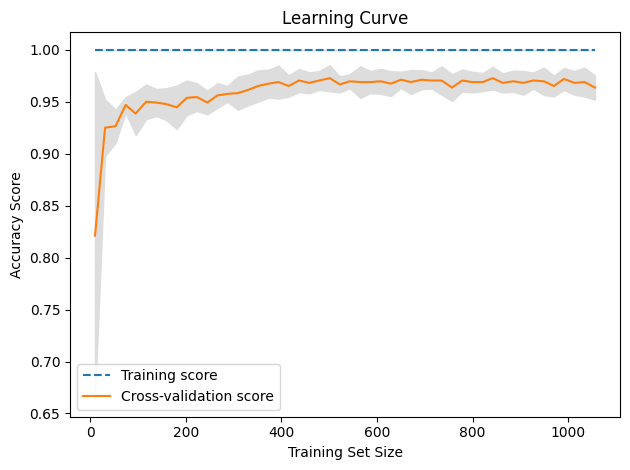

In [13]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(**grid.best_params_), 
                                                        X_train_scaled, 
                                                        y_train,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Define colors
train_color = "#1f77b4"  # Blue
test_color = "#ff7f0e"   # Orange
std_color = "#DDDDDD"    # Light gray

# Draw lines
plt.plot(train_sizes, train_mean, '--', color=train_color,  label="Training score")
plt.plot(train_sizes, test_mean, color=test_color, label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color=std_color)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color=std_color)

# Create plot
plt.title("Learning Curve")
plt.grid(False)  # Disable grid
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [17]:
confusion = confusion_matrix(y_test, y_pred)


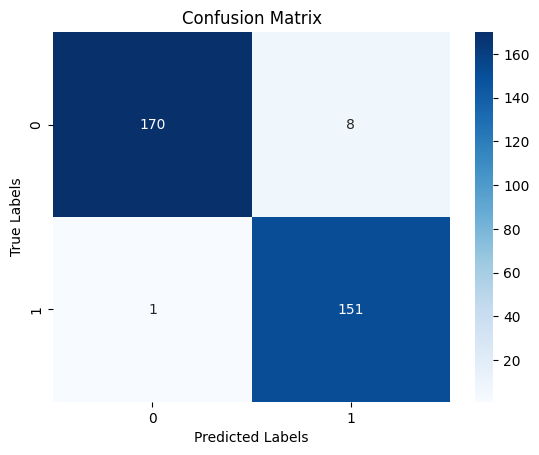

ROC-AUC Score: 0.97423861620343


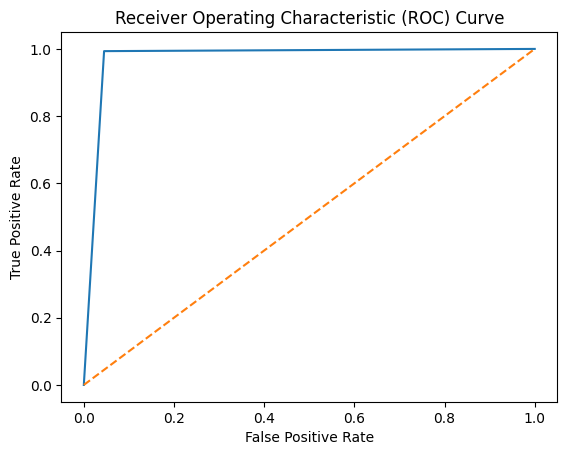

In [18]:
# Create a confusion matrix heatmap using Seaborn
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Plotting the random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
